# Mass Extraction Issue

First the reading of the two point correlators

In [1]:
#Library Import
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import sys
sys.path.insert(1, '../')
from building_blocks_reader import bulding_block
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#folders where the dataset is
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/3PointCorrelation/T6/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/2PointCorrelation/"

#instance of the building block class
bb = bulding_block(p3fold,p2fold, maxConf=100, verbose=True)


Initializing the building block class instance...


Looping over the configurations to read the building blocks from the h5 files...



100%|██████████| 100/100 [04:01<00:00,  2.41s/it]



Looping over the configurations to read the 2-point correlators from the h5 files...



100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


In [3]:
#The two point correlators are then given by
p2corr = bb.p2_corr.real
#with shape (nconf,latT)
np.shape(p2corr)

#the time extent of the lattice is
latT = np.shape(p2corr)[1]

(100, 48)

Now an implementation of the effective mass formula

$m_{eff}(t + \frac{1}{2}) = \log{\frac{C_{2p}(t)}{C_{2p}(t+1)}}$

In [4]:
#first we take the average over the gauge configurations
p2corr_gavg = np.mean(p2corr, axis=0)

#we instantiate an empty array (filled with zeros) for the mass
meff = np.zeros(shape=(latT-1,))

#we iterate over the times and compute meff according to the above formula
for t in range(latT-1):
    ratio = p2corr_gavg[t] / p2corr_gavg[t+1]
    if ratio > 1.0:
        meff[t] = np.log(ratio)
    #ratio should be bigger than 1 for the mass to positve, so for values <= 1.0 we leave meff=0

A plot of the effective mass

<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 't')

Text(0, 0.5, '$m_{eff}$')

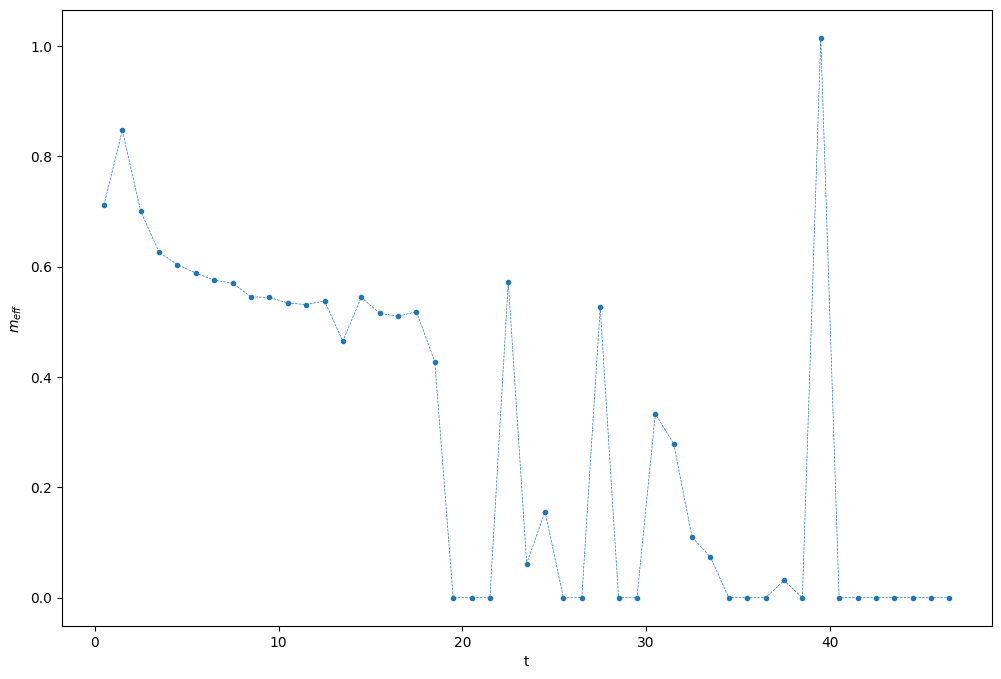

In [5]:
#on the y axis there is meff
#on the x axis we have the times
times = np.arange(latT-1) + 0.5

#we make the plot
plt.figure(figsize=(12,8))
plt.xlabel("t")
plt.ylabel(r"$m_{eff}$")
plt.plot(times, meff, marker='o', markersize=3, linestyle='dashed', linewidth=0.5)

# Using scipy fit

In [6]:
from scipy.optimize import curve_fit

def exp_fit_func(t: np.ndarray, amp: float, mass: float) -> np.ndarray:
    #we just return the exponential
    return amp * np.exp(-t * mass)

In [7]:
#then we define the first guess for the parameters of the fit
guess_amp = p2corr_gavg[0]
guess_mass = 0.5
guess = [guess_amp,guess_mass]

#we cut certain values
cut = 5

#we define the x and y arrays used for the fit (which are respectively times and p2corr_gavg)
times = np.arange(np.shape(p2corr_gavg)[0])[cut:-cut]
fit_data = p2corr_gavg[cut:-cut]

#we perform the fit
popt,pcov = curve_fit(exp_fit_func, times, fit_data, p0=guess)#,maxfev = 1300) #popt,pcov being mean and covariance matrix of the parameters extracted from the fit
perr = np.sqrt(np.diag(pcov)) #perr being the std of the parameters extracted from the fit

#we read the mass (that's the only thing we're interested about, the amplitude we discard)
fit_mass = popt[1]
fit_mass_std = perr[1]

fit_mass
fit_mass_std

np.float64(0.5773625736806565)

np.float64(0.0018767622600099239)

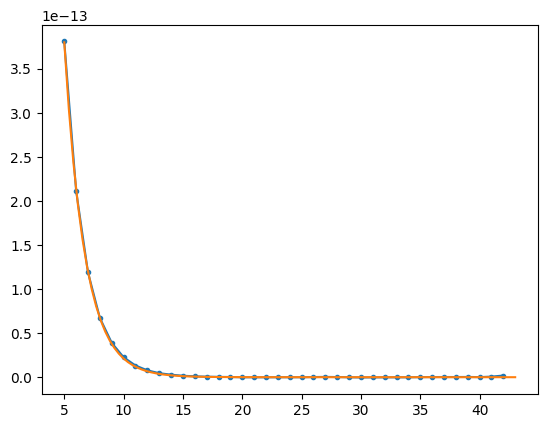

In [8]:
#plot
plt.plot(times,fit_data, marker='o', markersize=3)
lin_times = np.linspace(cut,np.shape(p2corr_gavg)[0]-cut,100)
plt.plot(lin_times,exp_fit_func(lin_times,*popt))

In [9]:
p2corr_gavg_std = np.std(p2corr, axis=0)[cut:-cut]

np.sum( (fit_data - exp_fit_func(times,*popt))**2 / p2corr_gavg_std**2 )

np.float64(0.9528206873764831)

In [10]:
a = 0.1163

fit_mass/a * 197.327

np.float64(979.6150006593542)